# Ensemble Pipeline

## Setting up the environment

In [ ]:
model_name = "doubleResFinal"
saving_path = "drive/My Drive/ScalableMLDL/Progetto/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 26 10:45:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
!pip install visualkeras
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 20.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 182 kB 42.3 MB/s 


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Download data

In [ ]:
!pip install awscli

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 40.6 MB/s 
     |████████████████████████████████| 662 kB 62.5 MB/s 
     |████████████████████████████████| 548 kB 93.6 MB/s 
     |████████████████████████████████| 10.3 MB 77.2 MB/s 
     |████████████████████████████████| 79 kB 8.7 MB/s 
     |████████████████████████████████| 140 kB 69.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: docutils
    Found existing installation: docutils 0.17.1
    Uninstalling docutils-0.17.1:

In [ ]:
!aws s3 --no-sign-request cp s3://open-images-dataset/tar/test.tar.gz test

download: s3://open-images-dataset/tar/test.tar.gz to ./test       


In [ ]:
!tar -xf test

### Moving the data into different folders


It is required for autoencoders when using Tensorflow Image Generator

In [ ]:
!mv test/ images/
!mkdir test
!mv images/ test/images

## Data Loader


In [ ]:
test_dir = "test"

In [ ]:
interpolation = "nearest"
batch_size = 8

In [ ]:
# Create an instance of ImageDataGenerator to visualize the result

test_data_gen = ImageDataGenerator(rescale=1/255., # rescale value is multiplied to the image
                                    fill_mode='reflect') 


test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='input',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=seed,
                                               keep_aspect_ratio=True,
                                               interpolation=interpolation)


Found 125436 images belonging to 1 classes.


## Ensemble model

### Models metadata

In [ ]:
input_shape = (256, 256, 3)
resized_shape = (128,128,3)

### Creating the ensemble model

In [ ]:
# building a model made by two networks: the actual autoencoder and the network with the resize layer before
def build_model(input_shape,resized_shape):
    
    model_versions = ["0","1","2","3","4","5","6","7","8","9","A","B","C","D","E","F"]
  
    autoencoders = []
    for letter in model_versions:
      temp_model = tfk.models.load_model(saving_path+"autoencoder_model_d_"+letter)
      temp_model._name = temp_model._name + letter
      autoencoders.append(temp_model)

    # Build the autoencoder network
    input_autoencoder = tfkl.Input(shape=resized_shape, name='input_autoencoder')

    intermediate_outputs = []
    for elem in autoencoders:
      intermediate_outputs.append(elem(input_autoencoder))

    output_autoencoder = tfkl.Average()(intermediate_outputs)
    
    autoencoder_model = tfk.Model(inputs=input_autoencoder, outputs=output_autoencoder, name='autoencoder')
    autoencoder_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam())

    # Build the entire network
    input_layer = tfkl.Input(shape=input_shape, name='input_resize')
    resize = tfkl.Resizing( resized_shape[-2],  resized_shape[-3], interpolation=interpolation, crop_to_aspect_ratio=True)(input_layer)
    output_layer = autoencoder_model(resize)
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='with_head')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam())

    # Return the model
    return model,autoencoder_model

### Baseline model used for the error

In [ ]:
def build_model_baseline(input_shape,resized_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input')
    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=input_layer, name='baseline')

    # Compile the model
    model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam())

    # Return the model
    return model

### Visualize the model

Model: "with_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_resize (InputLayer)   [(None, 256, 256, 3)]     0         
                                                                 
 resizing_11 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 autoencoder (Functional)    (None, 256, 256, 3)       185018480 
                                                                 
Total params: 185,018,480
Trainable params: 185,018,480
Non-trainable params: 0
_________________________________________________________________


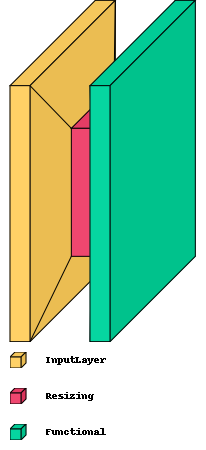

In [ ]:
# Build model
model, autoencoder_model = build_model(input_shape,resized_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_autoencoder (InputLayer)  [(None, 128, 128, 3  0          []                               
                                )]                                                                
                                                                                                  
 autoencoder0 (Functional)      (None, 256, 256, 3)  11563655    ['input_autoencoder[0][0]']      
                                                                                                  
 autoencoder1 (Functional)      (None, 256, 256, 3)  11563655    ['input_autoencoder[0][0]']      
                                                                                                  
 autoencoder2 (Functional)      (None, 256, 256, 3)  11563655    ['input_autoencoder[0][

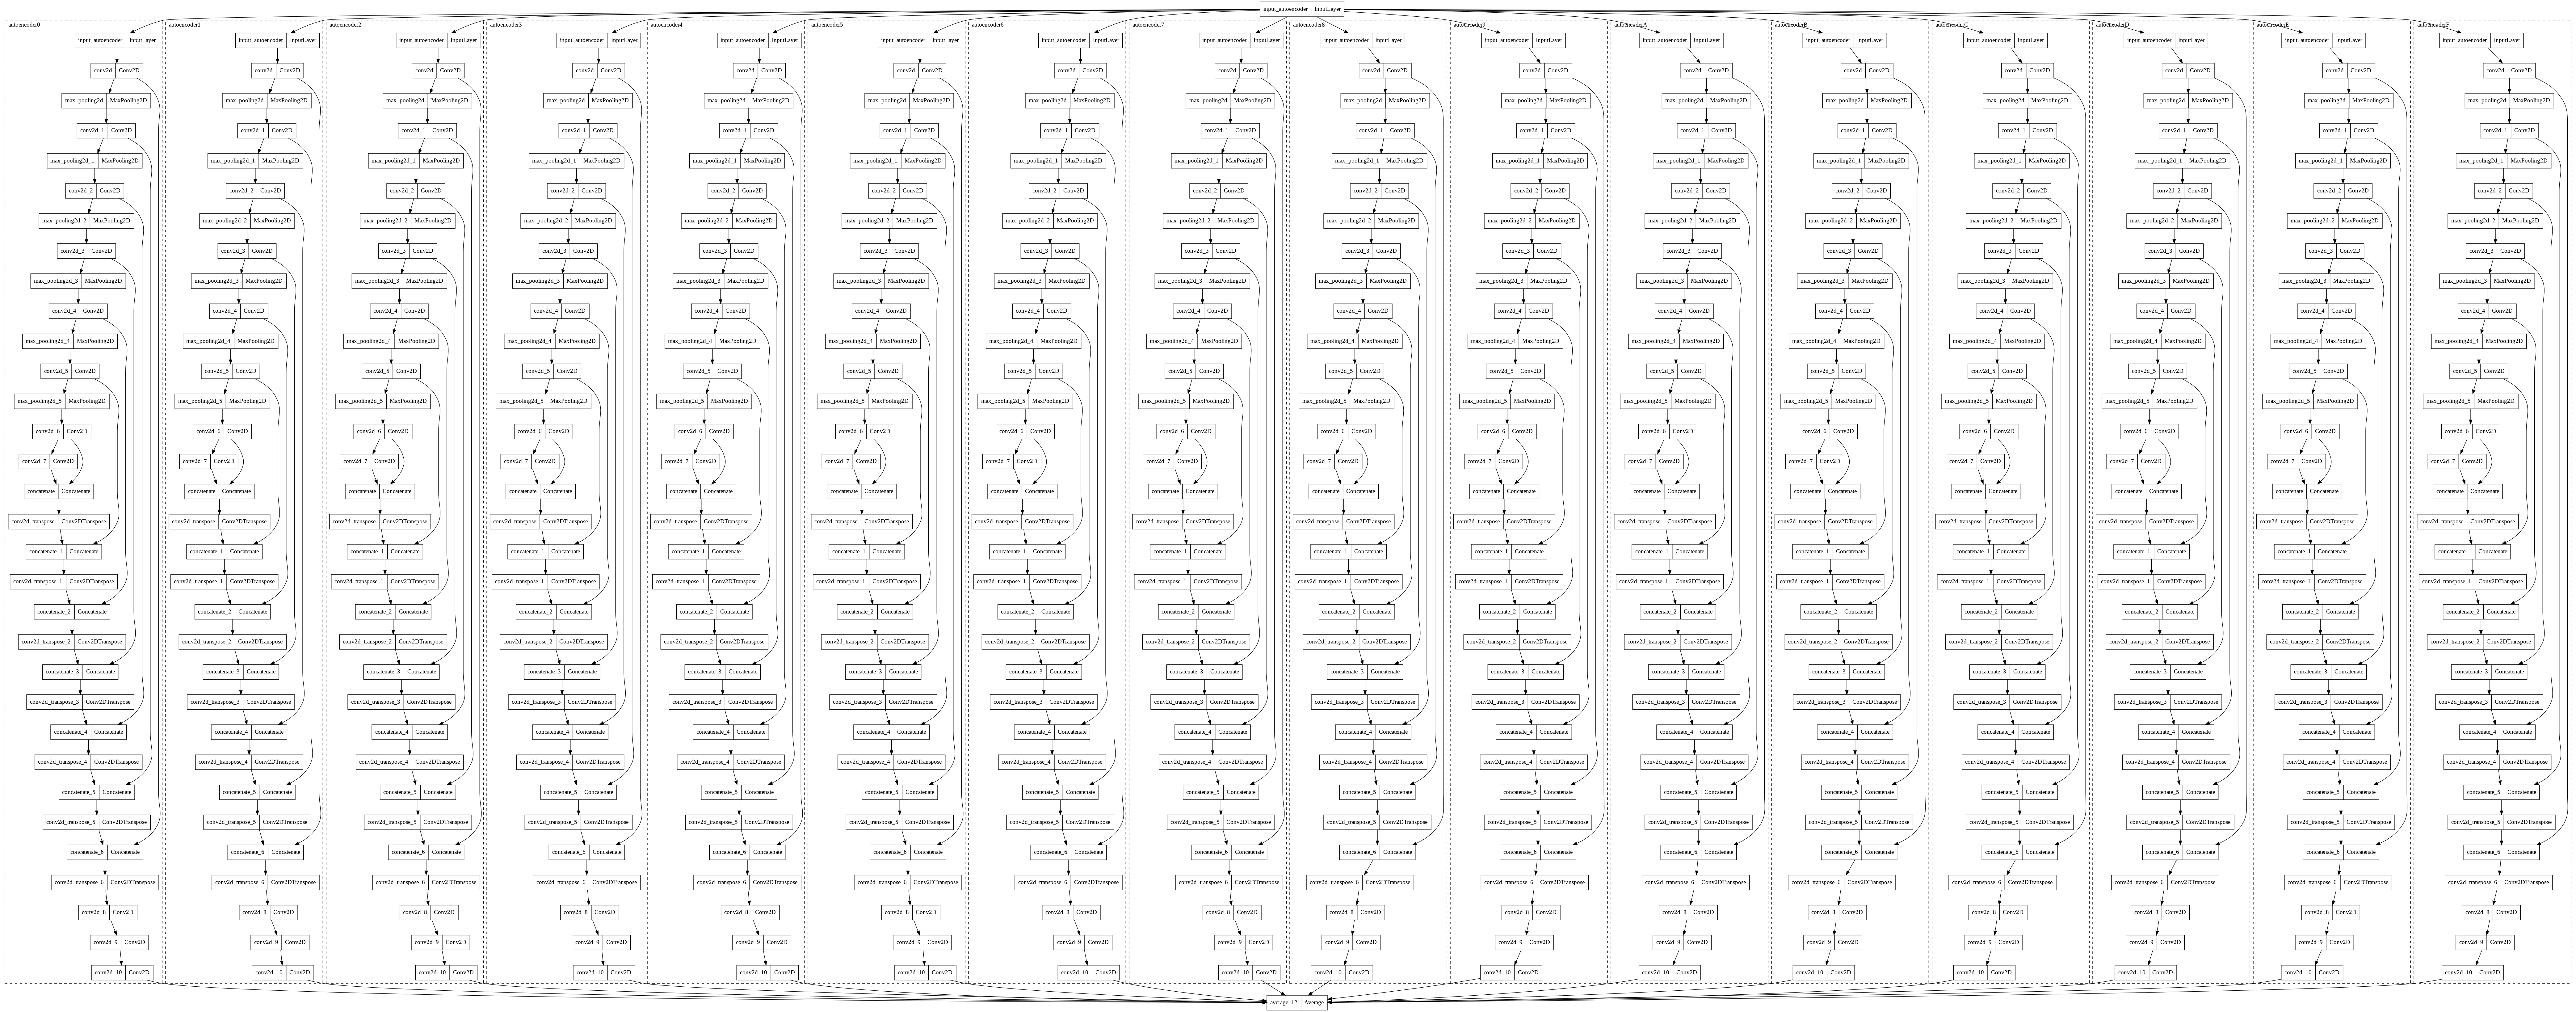

In [ ]:
autoencoder_model.summary()
tfk.utils.plot_model(autoencoder_model, expand_nested=True)

In [ ]:
autoencoder_model.save(saving_path+model_name)

### Saving the model on huggingface

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(autoencoder_model, "GIanlucaRub/"+model_name)

## Testing

### Testing the model

In [ ]:
# Evaluate on test
model_test_metrics = model.evaluate(test_gen)


print(model_test_metrics)

 6593/15680 [===========>..................] - ETA: 1:07:27 - loss: 0.5016

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:2797: DecompressionBombWarning: Image size (102539736 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


15680/15680 [==============================] - 6994s 446ms/step - loss: 0.5021
0.5020714402198792


### Visualizing the prediction

1/1 [==============================] - 5s 5s/step
(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 256, 256, 3)



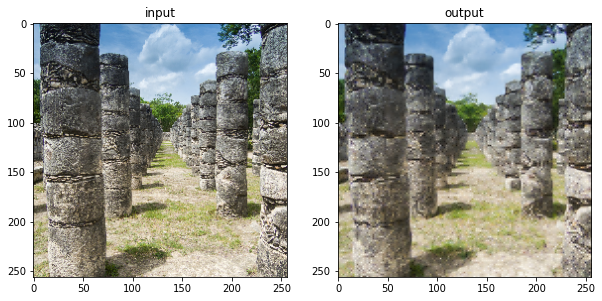

In [ ]:
# Visualize the transformation
def predict_next_batch(generator,autoencoder):
  batch = next(generator)
  image = batch[0]
  target = autoencoder.predict(batch[0])

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  print()
  fig = plt.figure(figsize=(10, 5))
  fig.add_subplot(1, 2, 1)
  plt.imshow(np.uint8(image*255))
  plt.title("input")
  fig.add_subplot(1, 2, 2)
  plt.imshow(np.uint8(target*255))
  plt.title("output")
  
  return batch

  
_ = predict_next_batch(test_gen,model) 

### Computing the baseline loss

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


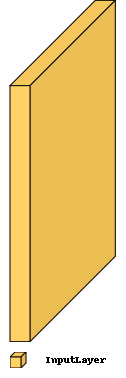

In [ ]:
# Build model
baseline_model = build_model_baseline(input_shape,resized_shape)
baseline_model.summary()
visualkeras.layered_view(baseline_model, legend=True, spacing=20, scale_xy=1)

In [ ]:
# Evaluate on test
baseline_model_test_metrics = baseline_model.evaluate(test_gen)


print(baseline_model_test_metrics)

15680/15680 [==============================] - 2530s 161ms/step - loss: 0.4928
0.4928123652935028


### Comparing the model loss with the baseline loss

There is just a very few percentage difference.

In [ ]:
diff = (model_test_metrics-baseline_model_test_metrics)/baseline_model_test_metrics*100

In [ ]:
diff

1.8788235804233409